        在物理学上，引力波是爱因斯坦广义相对论所预言的一种以光速传播的时空波动，如同石头丢进水里产生的波纹一样，引力波被视为宇宙中的“时空涟漪”。通常引力波的产生非常困难，地球围绕太阳以每秒30千米的速度前进，发出的引力波功率仅为200瓦，还不如家用电饭煲功率大。宇宙中大质量天体的加速、碰撞和合并等事件才可以形成强大的引力波，但能产生这种较强引力波的波源距离地球都十分遥远，传播到地球时变得非常微弱。
        
        激光干涉引力波观测站（Laser Interferometer Gravitational-Wave Observatory）LIGO是加州理工学院（Caltech）和麻省理工学院（MIT）的合作实验室，现在也有其他的大学参与。实验资金来源于美国国家科学基金会。LIGO是用来寻找宇宙中的引力波，从而可以验证黑洞的存在和检验广义相对论。

https://blog.csdn.net/c602273091/article/details/50663833

### 绘制LIGO的功率谱  http://astroML.github.com  astroML示例

## 比较使用原始FFT和Welch方法计算出的功率谱（即减少噪声的重叠窗口函数）。


图一显示原始信号，它是基线长度变化的度量。 


图二显示了原始的和平滑的功率谱，LIGO团队使用它来表征检测器的噪声。LIG0 http://www.ligo.org/news/blind-injection.php

In [12]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import fftpack   # 傅里叶变换
from matplotlib import mlab

from astroML.datasets import fetch_LIGO_large   # 拉取 LIGO 数据

###  拉取数据   

fetch_LIGO_large()

In [13]:
data, dt = fetch_LIGO_large()

# subset of the data to plot
t0 = 646
T = 2
tplot = dt * np.arange(T * 4096)
dplot = data[4096 * t0: 4096 * (t0 + T)]

tplot = tplot[::10]
dplot = dplot[::10]

fmin = 40
fmax = 2060

### 信号的功率谱密度(周期图求PSD)

###  FFT 计算  PSD


功率谱密度与幅度变换之间的关系,具体的步骤是:

信号S经过FFT变换,再除以N,取左半部分,即 1:N/2+1;

(1)  对其进行取abs,
然后两端数值保持不变,对中间部分乘以2(因为对称性),即得到对应的幅频部分;

(2)  对其进行取abs,并进行平方运算,再除以采样速率Fs,
然后两端数值保持不变,对中间部分乘以2(因为对称性),即得到对应的功率谱密度部分;
对应的频率范围为 f = Fs*(0:(L/2))/L; 即 freq = 0:Fs/length(S):Fs/2;
2.1 对2中对应的功率谱密度数值取对数,即为周期图Periodogram求PSD


In [14]:
# compute PSD using simple FFT
N = len(data)
df = 1. / (N * dt)
PSD = abs(dt * fftpack.fft(data)[:N // 2]) ** 2
f = df * np.arange(N / 2)

cutoff = ((f >= fmin) & (f <= fmax))
f = f[cutoff]
PSD = PSD[cutoff]
f = f[::100]
PSD = PSD[::100]

###  汉宁窗计算 PSD

In [22]:
# compute PSD using Welch's method -- hanning window function

PSDW2, fW2 = mlab.psd(data, NFFT=4096, Fs=1. / dt,
                      window=mlab.window_hanning, noverlap=2048)

dfW2 = fW2[1] - fW2[0]

cutoff = (fW2 >= fmin) & (fW2 <= fmax)
fW2 = fW2[cutoff]
PSDW2 = PSDW2[cutoff]


### 画图

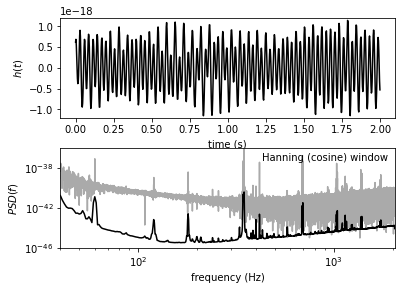

In [21]:
fig = plt.figure()
fig.subplots_adjust(bottom=0.1, top=0.9, hspace=0.3)


### time series 原始曲线

ax = fig.add_subplot(211)
ax.plot(tplot, dplot, '-k')
ax.set_xlabel('time (s)')
ax.set_ylabel('$h(t)$')

ax.set_ylim(-1.2E-18, 1.2E-18)


### 汉宁窗

ax = fig.add_subplot(212)
ax.loglog(f, PSD, '-', c='#AAAAAA')
ax.loglog(fW2, PSDW2, '-k')
ax.text(0.98, 0.95, "Hanning (cosine) window",
        ha='right', va='top', transform=ax.transAxes)

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel(r'$PSD(f)$')

ax.set_xlim(40, 2060)
ax.set_ylim(1E-46, 1E-36)
ax.yaxis.set_major_locator(plt.LogLocator(base=100))

plt.show()